#  TP 3: 

### 14 avril 2024

### Par Samuel Fortin, Philippe Truchon et Benjamin Trudel

## TP3.1 Mécanique céleste - la Terre

### a)

Utilisez la m´ethode de Verlet pour calculer l’orbite de la Terre autour du soleil, consid´erant
que le mouvement est d´ecrit par

$\frac{d^2r}{dt^2} = -GM \frac{r}{r^3}$

et sachant que la distance du périhélie est de 1.4710×1011 m et que la vitesse tangentielle
à cette position est de 3.0287 × 104 m/s (utilisez le module astropy pour les autres
constantes nécessaires). Utilisez un incrément temporel h = 1 heure. Représentez graphiquement
plusieurs orbites, qui devraient appaître légèrement non-circulaires.

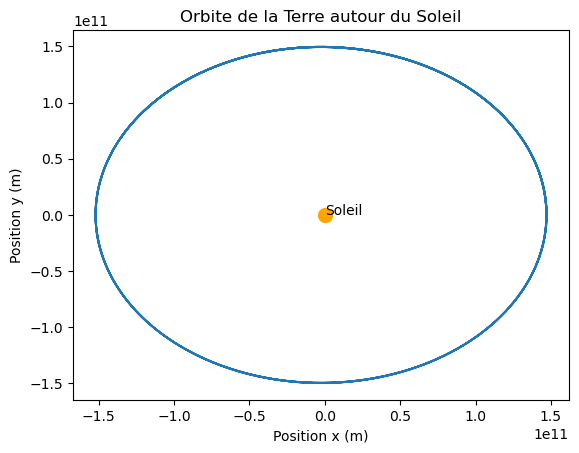

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy import constants as const
from numpy import empty,imag
from numpy.fft import rfft,irfft

# Constantes
G = const.G.value  # Constante gravitationnelle
M = const.M_sun.value  # Masse du Soleil
m = const.M_earth.value  # Masse de la Terre

# Paramètres de simulation
dt = 3600  # 1 heure en secondes
steps = 30000  # Nombre de pas de temps

# Conditions initiales au périhélie
r_peri = 1.4710e11  # Position initiale au périhélie en mètres
v_peri = 3.0287e4  # Vitesse initiale au périhélie en m/s
r0 = np.array([r_peri, 0])  # Position initiale
v0 = np.array([0, v_peri])  # Vitesse initiale

# Fonction d'accélération
def acc(r):
    return -G * M * r / np.linalg.norm(r)**3

# Fonction de Verlet
def verlet(r0, v0, dt, steps):
    positions = np.zeros((steps, 2))
    positions[0] = r0
    r = np.copy(r0)
    v = np.copy(v0)

    for i in range(1, steps):
        a = acc(r)
        r = r + v * dt + 0.5 * a * dt**2  # Mise à jour de la position
        a_new = acc(r)  # Nouvelle accélération basée sur la nouvelle position
        v = v + 0.5 * (a + a_new) * dt  # Mise à jour de la vitesse

        positions[i] = r

    return positions

# Exécution de la simulation
positions = verlet(np.array([r_peri, 0]), np.array([0, v_peri]), dt, steps)

# Tracé de l'orbite
plt.plot(positions[:, 0], positions[:, 1])
plt.scatter(0, 0, color='orange', s=100, label='Soleil')  
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')
plt.title('Orbite de la Terre autour du Soleil')
plt.text(0, 0, 'Soleil')
plt.show()

Figure 1: Comme on peut le voir sur cette figure, même si la terre effectue plus qu'une rotation, l'énergie est conservée et l'orbite reste pratiquement la même.

### b)

Modifiez votre programme pour qu’il calcule aussi l’énergie potentielle $-GMm/r$ et
cinétique $\frac{1}{2}mv^2$ à chaque pas, ainsi que la somme (énergie totale) de ces deux quantitées.
Rapportez ces valeurs en fonction du temps dans un graphique et commentez.

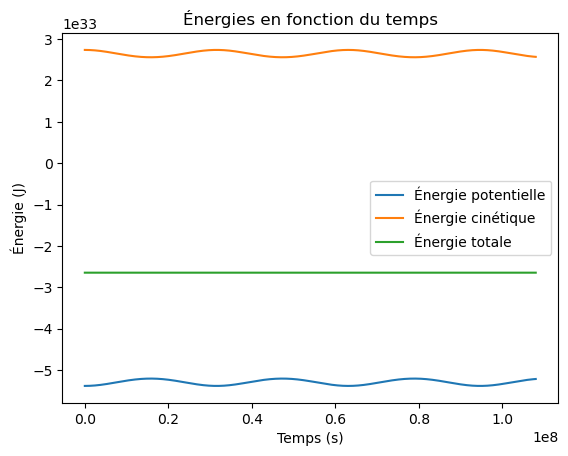

In [2]:
# Énergie potentielle
def U(r):
    return -G * M * m / np.linalg.norm(r)

# Énergie cinétique
def KE(v):
    return 0.5 * m * np.linalg.norm(v)**2

# Énergie totale
def E(U, KE):
    return U + KE

# Fonction de Verlet pour le calcul des énergies
def verlet(r0, v0, dt, steps):
    r = np.copy(r0)
    v = np.copy(v0)
    positions = [r0]
    Pot = [U(r0)]  # Calcul initial de l'énergie potentielle
    Cin = [KE(v0)]  # Calcul initial de l'énergie cinétique
    Energie_tot_Verlet = [E(Pot[0], Cin[0])]  # Calcul initial de l'énergie totale

    for i in range(1, steps):
        a = acc(r)
        r += v * dt + 0.5 * a * dt**2  # Mise à jour de la position
        a_new = acc(r)
        v += 0.5 * (a + a_new) * dt  # Mise à jour de la vitesse

        positions.append(r)
        Pot.append(U(r))  # Mise à jour de l'énergie potentielle
        Cin.append(KE(v))  # Mise à jour de l'énergie cinétique
        Energie_tot_Verlet.append(E(Pot[-1], Cin[-1]))  # Mise à jour de l'énergie totale

    return np.array(positions), np.array(Pot), np.array(Cin), np.array(Energie_tot_Verlet)

# Appel de la fonction verlet pour obtenir les valeurs des énergies
orbite, Pot, Cin, Energie_tot_Verlet = verlet(r0, v0, dt, steps)

time_values = np.arange(len(Pot)) * dt

# Plot des énergies en fonction du temps
plt.plot(time_values, Pot, label='Énergie potentielle')
plt.plot(time_values, Cin, label='Énergie cinétique')
plt.plot(time_values, Energie_tot_Verlet, label='Énergie totale')
plt.xlabel('Temps (s)')
plt.ylabel('Énergie (J)')
plt.title('Énergies en fonction du temps')
plt.legend()
plt.show()

Figure 2: Comme on peut le voir sur ce graphique, l'énergie cinétique est positive, l'énergie potentielle est négative et la somme des deux est elle aussi négative et constante. Le fait que cette somme des énergie soit négative et aussi constante nous permet de confirmer que la terre est bel et bien en orbite stable autour du soleil. En effet, une énergie cinétique supérieure à l'énergie potentielle engendrerait la sortie d'orbite de la terre.

### c)

Utilisez maintenant la méthode d’Euler, RK2 et RK4 pour calculer l’orbite de la Terre
et l’énergie totale en fonction du temps, que vous rapportez sur le même graphique que
l’énergie totale en fonction du temps calculée par la méthode de Verlet. Votre graphique
devrait montrer le caractère symplectique de la méthode de Verlet vs Euler/RK2/RK4.

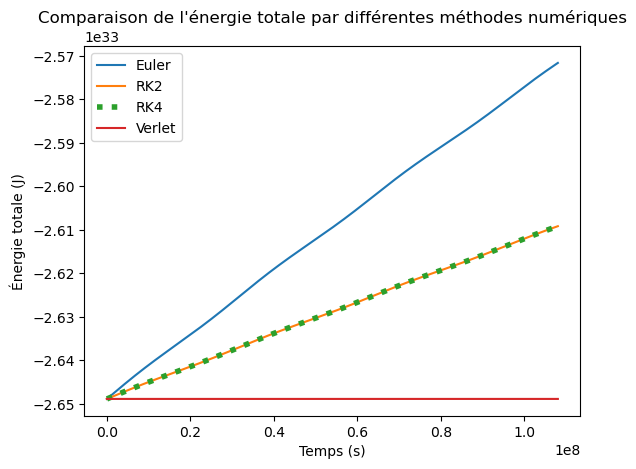

In [3]:
# Méthode d'Euler
def Euler(r0, v0, dt, steps):
    r = np.copy(r0)
    v = np.copy(v0)
    positions = [r0]
    Pot = [U(r0)]
    Cin = [KE(v0)]
    Energie_tot = [E(Pot[0], Cin[0])]

    for _ in range(steps):
        k = acc(r)
        r_new = r + v * dt
        v_new = v + k * dt
        positions.append(r_new)
        Pot.append(U(r_new))
        Cin.append(KE(v_new))
        Energie_tot.append(E(Pot[-1], Cin[-1]))

        r = r_new
        v = v_new
        
    return np.array(positions), np.array(Pot), np.array(Cin), np.array(Energie_tot)

#Méthode de Runge-Kutta 2 
def RK2(r0, v0, dt, steps):
    r = r0
    v = v0
    positions = [r0]
    Pot = [U(r0)]
    Cin = [KE(v0)]
    Energie_tot = [E(Pot[0], Cin[0])]
    
    for _ in range(steps):
        k1 = dt * acc(r)
        k2 = dt * acc(r + 0.5 * v * dt + 0.25 * k1)
        
        r_new = r + v * dt + 0.5 * k1
        v_new = v + k2

        positions.append(r_new)
        Pot.append(U(r_new))
        Cin.append(KE(v_new))
        Energie_tot.append(E(Pot[-1], Cin[-1]))
        
        r = r_new
        v = v_new
        
    return np.array(positions), np.array(Pot), np.array(Cin), np.array(Energie_tot)

#Méthode de Runge-Kutta 4
def RK4(r0, v0, dt, steps):
    r = r0
    v = v0
    positions = [r0]
    Pot = [U(r0)]
    Cin = [KE(v0)]
    Energie_tot = [E(Pot[0], Cin[0])]
    
    for _ in range(steps):
        k1 = dt * acc(r)
        k2 = dt * acc(r + 0.5 * v * dt + 0.25 * k1)
        k3 = dt * acc(r + 0.5 * v * dt + 0.25 * k2)
        k4 = dt * acc(r + v * dt + 0.5 * k3)
        
        r_new = r + v * dt + (k1 + 2*k2 + 2*k3 + k4) / 6
        v_new = v + (k1 + 2*k2 + 2*k3 + k4) / 6

        positions.append(r_new)
        Pot.append(U(r_new))
        Cin.append(KE(v_new))
        Energie_tot.append(E(Pot[-1], Cin[-1]))
        
        r = r_new
        v = v_new
        
    return np.array(positions), np.array(Pot), np.array(Cin), np.array(Energie_tot)

# Méthode de Verlet
def verlet(r0, v0, dt, steps):
    r = np.copy(r0)
    v = np.copy(v0)
    positions = [r0]
    Pot = [U(r0)]  # Calcul initial de l'énergie potentielle
    Cin = [KE(v0)]  # Calcul initial de l'énergie cinétique
    Energie_tot_Verlet = [E(Pot[0], Cin[0])]  # Calcul initial de l'énergie totale

    for _ in range(steps):
        k = acc(r)
        v_half = v + 0.5 * k * dt
        r = r + v_half * dt
        k_new = acc(r)
        v = v_half + 0.5 * k_new * dt
        
        positions.append(r)
        Pot.append(U(r))
        Cin.append(KE(v))
        Energie_tot_Verlet.append(E(Pot[-1], Cin[-1]))

    return np.array(positions), np.array(Pot), np.array(Cin), np.array(Energie_tot_Verlet)

# Appel des méthodes
_, Pot_Euler, Cin_Euler, Energie_tot_Euler = Euler(r0, v0, dt, steps)
_, Pot_RK2, Cin_RK2, Energie_tot_RK2 = RK2(r0, v0, dt, steps)
_, Pot_RK4, Cin_RK4, Energie_tot_RK4 = RK4(r0, v0, dt, steps)
_, Pot_Verlet, Cin_Verlet, Energie_tot_Verlet = verlet(r0, v0, dt, steps)

time_values = np.arange(len(Pot_Verlet)) * dt

# Tracé des énergies totales pour toutes les méthodes
plt.plot(time_values, Energie_tot_Euler, label='Euler')
plt.plot(time_values, Energie_tot_RK2, label='RK2')
plt.plot(time_values, Energie_tot_RK4, lw=4, ls=':', label='RK4')
plt.plot(time_values, Energie_tot_Verlet, label='Verlet')
plt.xlabel('Temps (s)')
plt.ylabel('Énergie totale (J)')
plt.title('Comparaison de l\'énergie totale par différentes méthodes numériques')
plt.legend()
plt.show()

Figure 3: Comme on peut le voir sur la figure ci-dessus, les énergies totales des méthodes d'Euler, RK2 et RK4 ne sont pas totalement conservées dans le temps. En effet, RK2 et RK4 augmentent similairement et Euler encore plus. Quant à elle, la méthode de Verlet conserve exactement la même quantité d'énergie à travers le temps.

### d)

Utilisez maintenant la méthode de Bulirsch-Stoer pour calculer l’orbite de la Terre,
avec une précision de 1 km par année (voir l’exemple 8.7 dans le Newman pour une
implémentation, que vous pouvez réutiliser). Utilisez un intervalle H de une semaine.
Comparez avec la précision obtenue avec les autres méthodes.

In [4]:
# Méthode de Bulirsch-Stoer
def bulirsch_stoer(r0, v0, dt, t_final, target_precision):
    def bulirsch_stoer_step(h):
        k1 = h * acc(r)
        k2 = h * acc(r + 0.5 * k1)
        k3 = h * acc(r + 0.75 * k2)
        r1 = r + (2/9) * k1 + (1/3) * k2 + (4/9) * k3
        k4 = h * acc(r1)
        k5 = h * acc(r + (7/24) * k1 + (1/4) * k2 + (1/3) * k3 + (1/8) * k4)
        k6 = h * acc(r + (h/2) * (k1 + 3*k4))
        
        # Extrapolation de Richardson
        R = (k5 - (12/5) * k4 + (8/5) * k3 - (12/25) * k2)
        
        # Estimation de l'erreur
        error = np.linalg.norm(R) / dt
        
        # Mise à jour du pas de temps avec ajustement pour atteindre la précision cible
        h_new = h * min(5, max(0.2, 0.9 * (target_precision / error) ** (1/4)))
        
        return r1, h_new
    
    r = r0
    v = v0
    t = 0
    h = dt
    positions = [r0]
    
    while t < t_final:
        r, h = bulirsch_stoer_step(h)
        t += h
        positions.append(r)
        
    return np.array(positions)

# Paramètres pour la comparaison
target_precision = 1e3  # 1 km par année
dt_week = 7 * 24 * 3600  # 1 semaine en secondes

# Calcul de l'orbite pour chaque méthode
orbite_bs_week = bulirsch_stoer(r0, v0, dt_week, steps * dt_week, target_precision)
orbite_euler_week, _, _, _ = Euler(r0, v0, dt_week, steps)
orbite_rk2_week, _, _, _ = RK2(r0, v0, dt_week, steps)
orbite_rk4_week, _, _, _ = RK4(r0, v0, dt_week, steps)
orbite_verlet_week, _, _, _ = verlet(r0, v0, dt_week, steps)

# Calcul de l'erreur pour chaque méthode
error_bs_week = np.linalg.norm(orbite_bs_week[-1] - orbite_bs_week[0])
error_euler_week = np.linalg.norm(orbite_euler_week[-1] - orbite_euler_week[0])
error_rk2_week = np.linalg.norm(orbite_rk2_week[-1] - orbite_rk2_week[0])
error_rk4_week = np.linalg.norm(orbite_rk4_week[-1] - orbite_rk4_week[0])
error_verlet_week = np.linalg.norm(orbite_verlet_week[-1] - orbite_verlet_week[0])

# Affichage des erreurs
print("Erreur avec la méthode de Bulirsch-Stoer: {:.2E} m".format(error_bs_week))
print("Erreur avec la méthode d'Euler: {:.2E} m".format(error_euler_week))
print("Erreur avec la méthode RK2: {:.2E} m".format(error_rk2_week))
print("Erreur avec la méthode RK4: {:.2E} m".format(error_rk4_week))
print("Erreur avec la méthode de Verlet: {:.2E} m".format(error_verlet_week))


Erreur avec la méthode de Bulirsch-Stoer: 5.28E+07 m
Erreur avec la méthode d'Euler: 8.47E+12 m
Erreur avec la méthode RK2: 2.27E+12 m
Erreur avec la méthode RK4: 2.37E+12 m
Erreur avec la méthode de Verlet: 2.35E+10 m


Comme ces erreurs nous le montrent, la méthode de Bulirsch-Stoer est bien plus précise que les quatres autres méthodes utilisées, passant d'une erreur de puissance 11 à une erreur de puissance 7.

## TP3.2 Mécanique céleste - Mars

### e)

Utilisez Bulirsch-Stoer pour calculer la position de Mars 203 jours plus tard, soit le 18
février 2021 (jour de l’atterrissage). Ne lésinez pas sur la précision, ¸ca coûte cher un
astromobile. Notez que les calculs seront effectués en trois dimensions. Comparez votre
position calculée à la valeur de l’éphéméride, soit
eph.position(’mars’,atterissage.jd). Commentez, notamment sur vos limites et
celles de la méthode utilisée, peut-être en vous inspirant d’informations à cette adresse$^1$.

1.https://en.wikipedia.org/wiki/Jet_Propulsion_Laboratory_Development_Ephemeris

In [ ]:
from jplephem import Ephemeris
import matplotlib.pyplot as plt
from astropy import constants
from astropy.time import Time
from numba import njit
import numpy as np
import de421

def return_ephemeris_data():
	x = []
	y = []
	z = []
	t = np.linspace(lancement.jd,atterrissage.jd,10000)
	for i in t:
		position, velocity = eph.position_and_velocity('mars',i)
		x_i,y_i,z_i = position
		x.append(x_i[0])
		y.append(y_i[0])
		z.append(z_i[0])
	return [x,y,z,t]

@njit(fastmath=True, nogil=True)
def bulirsch_stoer(y, t, tf, dt, tol=1e-3, n_steps=4):

	def acceleration(rv):
		r, v = rv[:3], rv[3:]
		a = (-r*G*M_sun)/(np.linalg.norm(r)**3)
		return np.concatenate((v, a))

	solution = [y]
	time_stamp = [t]

	while t < tf:
		H = dt / np.power(2, np.arange(1, n_steps))
		R = np.empty((H.size, y.size))

		ym = y + 0.5 * dt * acceleration(y)
		R2 = y + dt * acceleration(ym)

		for n, h in enumerate(H):
			ym = y + 0.5 * h * acceleration(y)
			R[n] = y + h * acceleration(ym)

			y_new = R2 + (R2 - R[-1]) / (dt / h)**2
			error = np.linalg.norm(y_new - R2)
			if error < tol:
				break

		if error >= tol:
			dt *= 0.5
		else:
			y = y_new
			t += dt
			solution.append(y)
			time_stamp.append(t)
			if error < tol / 10:
				dt *= 1.2

	return solution, time_stamp

# Constante

G = constants.G.value*7.46304 # en km^3/(kg * jour^2)
M_sun = constants.M_sun.value

eph = Ephemeris(de421)
atterrissage = Time("2021-02-18")
lancement = Time("2020-07-30")

# Calcul de la trajectoire 

position, velocity = eph.position_and_velocity('mars',lancement.jd)

r0 = np.asarray((position[0][0], position[1][0], position[2][0]))
v0 = np.asarray((velocity[0][0], velocity[1][0], velocity[2][0]))
y0 = np.concatenate((r0, v0))
tol = 1e4

solution, time_stamp = bulirsch_stoer(y0, lancement.jd, atterrissage.jd, 1, tol, 4)
solution = np.asarray(solution)
x,y,z,t = return_ephemeris_data()

# Pour la comparaison dans la prochaine cellule
time_stamp = time_stamp - lancement.jd
t = t-lancement.jd

ax = plt.figure().add_subplot(projection='3d')
ax.plot(0,0,0,marker=".", markersize=40, color="#FF7C00")
ax.plot(x,y,z, color="r", linewidth=2.0, label="Courbe de référence")
ax.plot(solution[:,0],solution[:,1],solution[:,2], linestyle="-.", color="#00FFEC",linewidth=2.0, label="Courbe calculé avec Bulirsh-Stoer")
plt.legend(loc=0)
plt.show()

On cherche à obtenir l'erreur sur la trajectoire:

In [ ]:
# On veut comparer notre solution avec les données

def return_ephemeris_data(t):
	x = []
	y = []
	z = []
	for i in t:
		position, velocity = eph.position_and_velocity('mars',i)
		x_i,y_i,z_i = position
		x.append(x_i[0])
		y.append(y_i[0])
		z.append(z_i[0])
	return [np.array(x),np.array(y),np.array(z)]

# Conditions initiales
atterrissage = Time("2021-02-18")
lancement = Time("2020-07-30")

position, velocity = eph.position_and_velocity('mars',lancement.jd)

r0 = np.asarray((position[0][0], position[1][0], position[2][0]))
v0 = np.asarray((velocity[0][0], velocity[1][0], velocity[2][0]))

y0 = np.concatenate((r0, v0))

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(12,3))

ax[0].set_ylabel("Δr [%]",fontsize=14)

errors = []

for j, tol in enumerate([1e9,1e8,1e7,1e6,1e5,1e4,1e3,1e2]):
	# Run Bulirsch-Stoer with Runge-Kutta method
	solution, time_stamp = bulirsch_stoer(y0, lancement.jd, atterrissage.jd, 1, tol, 4)
	solution = np.asarray(solution)

	x,y,z = return_ephemeris_data(time_stamp)

	error = 100*np.sqrt( (solution[:,0][-1]-x[-1])**2 + (solution[:,1][-1]-y[-1])**2 + (solution[:,2][-1]-z[-1])**2 )/np.sqrt(x[-1]**2+y[-1]**2+z[-1]**2)
	errors.append(error)
	time_stamp = time_stamp - lancement.jd

	ax[j].plot(time_stamp,100*np.sqrt( (solution[:,0]-x)**2 + (solution[:,1]-y)**2 + (solution[:,2]-z)**2 )/np.sqrt(x**2+y**2+z**2))
	ax[j].set_xlabel("jours")

for i,x in enumerate(["1e9","1e8","1e7","1e6","1e5","1e4","1e3","1e2"]):
	print("Tolérance de",x,":",errors[i],"%")
plt.show()

On observe sur les graphiques plus haut qu'à partir d'une tolérance de $1\times 10^5$ km on atteint un plateau avec une erreur d'environ 4% par rapport à la valeur réelle. La limite de notre modèle n'est pas la méthode numérique de bulirsch-Stoer mais bien le modèle utilisé. En effet, on utilise le modèle de Newton pour prédire la position de la planète à partir de données initiales. Ce modèle est très simpliste et néglige énormément de paramètre comme l'influence des autres planètes sur l'orbite de Mars, notamment l'influence de Jupiter. On peut augmenter la précision d'une facteur infini et nous n'obtiendrons pas de changement significatif sur la position de Mars après 203 jours. Pour cela, il faudrait changer de modèle et, par exemple, faire une simulation à n corps simulant le système solaire au complet ou du moins toutes les planètes du système solaire.

### f)

Quelle méthode numérique la NASA utilise-t-elle pour envoyer des sondes vers Mars ?

La NASA n'utilise pas qu'une seule méthode numérique. En effet, la NASA a développé un logiciel open-source nommé GMAT (General Mission Analysis Tool) et elle nous met à disposition toutes ces méthodes numériques:


* RungeKutta89
* PrinceDormand78
* PrinceDormand853
* PrinceDormand45
* RungeKutta68
* RungeKutta56
* AdamsBashforthMoulton

La plupart de ces méthodes peuvent obtenir des précisions en dessous du mètre sur un bon modèle.

Source: https://documentation.help/GMAT/Propagator.html#Propagator_NumericalPropagator

### g)

Cette méthode est-elle en cause dans la perte du Mars Climate Orbiter en 1999 ? Si non,
quelle a été la cause de cette perte ?

Non la méthode numérique de calcul n'est pas la cause de la perte du Mars Climate Orbiter en 1999. La cause de la perte est une confusion d'unité. En effet, les valeurs de poussée du moteur de freinage n'était pas exprimée dans le système internationnal. Ce qui causa sa destruction par l'atmosphère de Mars.

## TP3.3 L’´equation de Schrödinger et la méthode spectrale

### h)

Ecrivez un programme pour calculer les valeurs des coefficients $b_k$, qui peuvent de façon
pratique être séparés en composantes réelles et imaginaires $(b_k = α_k + iη_k)$. Divisez la
boîte en N = 1000 tranches et créez deux conteneurs pour les parties rélles et imaginaires
de $\psi(x_n, 0)$ à chaque point de la grille. Effectuez une transformée en sinus pour chaque
conteneur séparément, i.e. calculez les valeurs de $α_k$ et $β_k$ pour k = 1...N − 1. Vous
utiliserez les fonctions du module dcst de Newman (Appendix E ou son site web).

In [ ]:
def dst(y): # Fonction de Newmann
    N = len(y)
    y2 = empty(2*N,float)
    y2[0] = y2[N] = 0.0
    y2[1:N] = y[1:]
    y2[:N:-1] = -y[1:]
    a = -imag(rfft(y2))[:N]
    a[0] = 0.0

    return a

M = 9.109e-31
L = 10e-8
x0 = L/2
sigma = 1e-10
kappa = 5e10
N = 1000
x = np.linspace(0,L,N)

def psi(x):
    return np.exp(-(x-x0)**2/(2*sigma**2))*np.exp(1j*kappa*x)

p = psi(x)
pr = p.real
pim = p.imag

ak = dst(pr)
nk = dst(pim)


### i)

Expliquez pourquoi Newman s’en remet à la fonction rfft de numpy pour calculer la
transformée en sinus.

La fonction rfft de numpy est une implémentation rapide du calcul de la transformée de Fourier réelle. Pour l'utiliser afin de réaliser une transformée en sinus, il suffit d'aggrandir la matrice de base pour créer les fréquences négatives necéssaire, ainsi que de rajouter les conditions frontières à 0. Une fois fait cette nouvelle matrice réalisée la transformée de Fourier réel est équivalente une transformée en sinus pour la matrice de base.

### j)

En injectant $b_k = α_k + iη_k$ dans la solution et en prenant la partie réelle, nous obtenons

$Re\psi(x_n, t) = \frac{1}{N}\sum_{k=1}^{N-1} \bigg[ \alpha_k cos \bigg( \frac{\pi^2\hbar k^2}{2ML^2}t \bigg) -\eta_k sin \bigg( \frac{\pi^2\hbar k^2}{2ML^2}t \bigg) \bigg] sin \bigg( \frac{\pi k n}{N} \bigg)$

pour la partie réelle de la fonction d’onde.
Une inspection vous convaincra qu’il s’agit de l’inverse d’une transformée en sinus pour
la quantité entre crochets. Complétez votre programme pour qu’il calcule la partie réelle
de $\psi(x_n, t)$ pour un t arbitraire à l’aide de la fonction idst fournie par Newman. Testez
votre programme en illustrant la fonction d’onde à t = 10−16 s.

In [ ]:
def idst(a):
    N = len(a)
    c = empty(N+1,complex)
    c[0] = c[N] = 0.0
    c[1:N] = -1j*a[1:]
    y = irfft(c)[:N]
    y[0] = 0.0

    return y

hbar = const.hbar.value

k = np.linspace(1,N-1,N)

def crochet(k, t, ak, hbar, M ,L, nk):
    return (ak*np.cos((np.pi**2*hbar*k**2)/(2*M*L**2)*t)-nk*np.sin((np.pi**2*hbar*k**2)/(2*M*L**2)*t))

#print(crochet(k, t, ak, hbar, M, L, nk))
def plot(t, i):
    
    psir = idst(crochet(k, t, ak, hbar, M, L, nk))
    plt.plot(x,psir, 'k')
    plt.ylim(-1*(1-i/1400),1*(1-i/1400))
    plt.xlim(0.4e-7*(1-i/1000),1e-7- 0.4e-7*(1-i/1000))
    plt.xlabel('Position [m]')
    plt.ylabel('$\\psi_{x,t}$ [$m^{-1/2}\\cdot s^{-1/2}$]')
fig =plt.figure(figsize=(16,4))
plot(10e-16, 1000)

plt.show()


### k)

Maintenant que tout est en place, vous pouvez produire une animation de l’évolution de
la fonction d’onde (normalisée) au cours du temps, en générant une image à plusieurs t
(utilisez un incrément de 10−18 s). Il y a probablement plusieurs façons d’y arriver, l’une
d’elle étant le package visual. Prenez soin d’ajuster le taux de rafraîchissement et les
échelles pour bien apprécier la dynamique de la fonction d’onde.

In [ ]:
import matplotlib.animation as animation

plt.rcParams['animation.embed_limit'] = 100
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['axes.labelpad'] = 20
plt.ioff()
def init():
    plt.cla()

def animate(i):
    plt.cla()
    plot(i*1e-17, i)

fig = plt.figure(figsize=(16,4))
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=1000, interval=50)
ani

In [ ]:
plt.close()
fig =plt.figure(figsize=(16,4))
plot(10e-12, 1000)
plt.show()

### l)

Laissez tourner votre animation un moment et décrivez ce que vous observez, en utilisant
bien entendu un langage se rapportant à la physique du problème.

La fonction d'onde commence très intense et localisée au centre de la boîte, car c'est l'allure donnée à t=0. Par la suite, celle-ci s'étend des 2 côtés de la boîte et perd en amplitude. À t=$\infty$, la fonction d'onde tend vers des fluctuations à même amplitude sur tout la largeur de la boîte. Alors, on retrouve ici un exemple de système qui suit la 2e loi de la thermodynamique même s'il est de nature quantique, car son entropie ne fait qu'augmenter au fil qu'il progesse dans le temps jusqu'à un équilibre avec entropie maximale décrite plus haut à t=$\infty$. Cependant, il est observé que le biais d'amplitude d'un côté du centre de la fonction initiale a une influence sur l'allure de la fonction d'onde avant qu'elle atteigne l'équilibre.